In [1]:
import pandas as pd
import numpy as np

In [2]:
import sys
sys.path.append('../lending_club')
import config
from data_prep import get_lending_club_data, refine_features

### Import file

In [9]:
%%time
approved = pd.read_pickle('../data/approved.pickle')

Wall time: 16.3 s


In [10]:
from model_prep import divide_by_term

df_60= divide_by_term(approved, 60)
df_36= divide_by_term(approved, 36)
approved = pd.concat([df_60,df_36],axis=0)

In [11]:
approved = approved.loc[approved['issue_d'].dt.year>2007,:]

In [6]:
approved.dtypes

addr_state                         object
annual_inc                        float64
application_type                   object
disbursement_method                object
dti                               float64
earliest_cr_line           datetime64[ns]
emp_length                          int64
emp_title                          object
fico_range_high                   float64
fico_range_low                    float64
grade                              object
home_ownership                     object
initial_list_status                object
inq_last_6mths                    float64
installment                       float64
int_rate                          float64
issue_d                    datetime64[ns]
last_pymnt_d               datetime64[ns]
loan_amnt                         float64
loan_status                         int64
open_acc                          float64
pub_rec                           float64
pub_rec_bankruptcies              float64
purpose                           

# EDA

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

In [13]:
approved['years']= approved['issue_d'].dt.year

In [215]:
approved['loan_status'].value_counts()

1    565404
0     95492
Name: loan_status, dtype: int64

In [216]:
1-(approved['loan_status'].mean())

0.14448869413644505

### What is the default rate? What are the defaults per loan grade?

In [217]:
default = approved['loan_status'].value_counts()
default
my_labels = ['Fully Paid','Charged Off']
my_colors = ['lightgreen','crimson']
my_explode = (0, 0.1)

Text(0.5, 1.0, 'Default Rate')

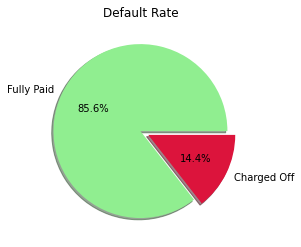

In [218]:
plt.pie(default, labels=my_labels, colors=my_colors, explode=my_explode, shadow = True, autopct='%1.1f%%')
plt.title('Default Rate')
#save

In [219]:
default_rate = approved.groupby('grade').agg({'loan_status':'mean'})
default_rate= 1-default_rate
default_rate = default_rate.reset_index()
default_rate

,grade,loan_status
0,A,0.055010
1,B,0.113535
2,C,0.182895
3,D,0.237949
4,E,0.294084


Text(0.5, 1.0, 'Default Rate per Loan Grade')

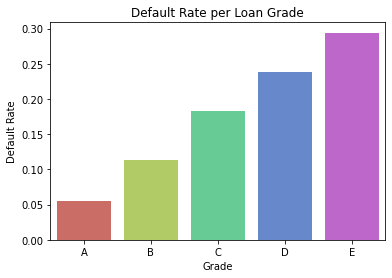

In [220]:
sns.barplot(y='loan_status',x='grade', data=default_rate, palette='hls')
plt.xlabel('Grade')
plt.ylabel('Default Rate')
plt.title('Default Rate per Loan Grade')
#save

In [221]:
default_rate = approved.groupby(['grade','term']).agg({'loan_status':'mean'})
default_rate= 1-default_rate
default_rate = default_rate.reset_index()
default_rate

,grade,term,loan_status
0,A,36,0.054767
1,A,60,0.083817
2,B,36,0.111894
3,B,60,0.155824
4,C,36,0.179117
5,C,60,0.217252
6,D,36,0.233172
7,D,60,0.272859
8,E,36,0.285661
9,E,60,0.311716


Text(0.5, 1.0, 'Default Rate per Loan Grade')

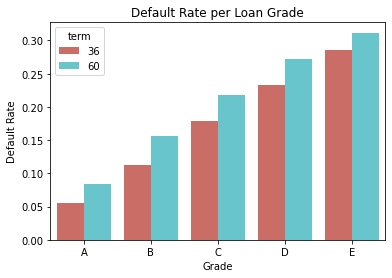

In [222]:
sns.barplot(y='loan_status',x='grade',hue='term', data=default_rate, palette='hls')
plt.xlabel('Grade')
plt.ylabel('Default Rate')
plt.title('Default Rate per Loan Grade')

In [224]:
approved['last_pymnt_d'].fillna(approved['issue_d'], inplace=True)

In [225]:
approved['default_year']=approved['last_pymnt_d'].dt.year

In [226]:
default_rate_year = approved.groupby(['years','term']).mean()['loan_status']
default_rate_year = 1-default_rate_year
default_rate_year = default_rate_year.reset_index()
default_rate_year

,years,term,loan_status
0,2008,36,0.150410
1,2009,36,0.124081
2,2010,36,0.097232
3,2010,60,0.203468
4,2011,36,0.105578
5,2011,60,0.225033
6,2012,36,0.135662
7,2012,60,0.259351
8,2013,36,0.122356
9,2013,60,0.234319


Text(0.5, 1.0, 'Default Rate Over Time')

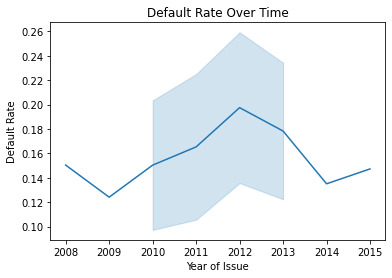

In [227]:
sns.lineplot(y='loan_status',x='years',data=default_rate_year)
plt.xlabel('Year of Issue')
plt.ylabel('Default Rate')
plt.title('Default Rate Over Time')

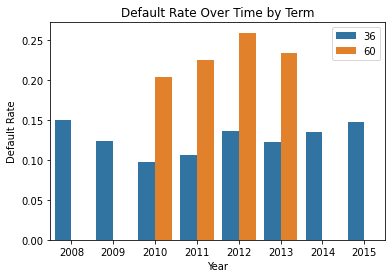

In [228]:
sns.barplot(y='loan_status',x='years',hue='term',data=default_rate_year)
plt.xlabel('Year')
plt.ylabel('Default Rate')
plt.title('Default Rate Over Time by Term')
plt.legend(loc=1)
#save

In [211]:
df_plot = approved.groupby(['years', 'term']).size().reset_index().pivot(columns='term', index='years', values=0)
df_plot

term,36,60
years,,
2008,1097.0,NaN
2009,4626.0,NaN
2010,8382.0,2826.0
2011,14037.0,6759.0
2012,43343.0,8448.0
2013,99799.0,29750.0
2014,160411.0,NaN
2015,281418.0,NaN


<AxesSubplot:xlabel='years'>

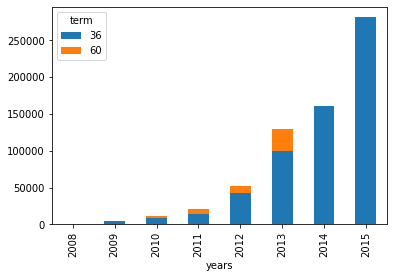

In [212]:
df_plot.plot(kind='bar', stacked=True)

Text(0.5, 1.0, 'Charged Off vs Fully Paid Over Time')

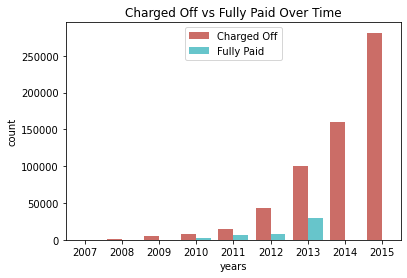

In [204]:
sns.countplot(x='years', hue='term', data=approved, palette='hls')
plt.legend(['Charged Off', 'Fully Paid'])
plt.title('Charged Off vs Fully Paid Over Time')

### Segmentation by FICO scores of the borrowers


Text(0.5, 1.0, 'FICO Score vs Grade')

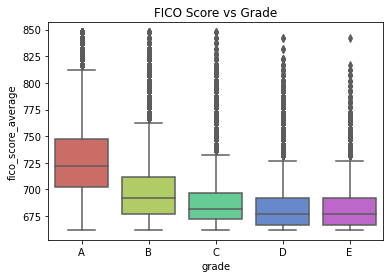

In [231]:
my_order = ['A','B','C','D','E']
sns.boxplot(x='grade', y='fico_score_average', data=approved, palette='hls',order=my_order)
plt.title('FICO Score vs Grade')

Text(0.5, 1.0, 'Interest Rate vs FICO Score')

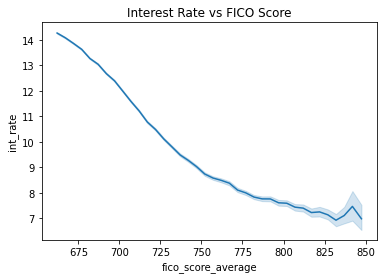

In [230]:
sns.lineplot(y='int_rate',x='fico_score_average', data=approved, palette='hls')
plt.title('Interest Rate vs FICO Score')

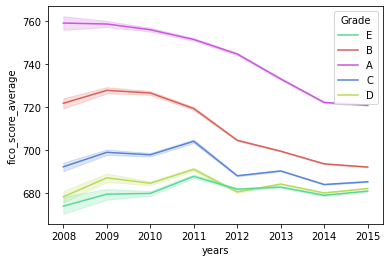

In [232]:
plt = sns.lineplot(y='fico_score_average',x= 'years', hue='grade', data=approved, palette='hls')

handles, labels = plt.get_legend_handles_labels()
handles = [handles[2], handles[0], handles[4], handles[3], handles[1]]
labels = [labels[2], labels[0], labels[4], labels[3], labels[1] ]
plt.legend(handles,labels, title='Grade', loc=1)
#save and fix legend
#fix fanning

In [233]:
default_fico = approved.groupby('fico_score_average').mean()['loan_status']
default_fico = 1-default_fico
default_fico

fico_score_average
662.0    0.198097
667.0    0.187555
672.0    0.181200
677.0    0.172124
682.0    0.169228
687.0    0.157534
692.0    0.148646
697.0    0.144033
702.0    0.132422
707.0    0.124893
712.0    0.116712
717.0    0.110796
722.0    0.099783
727.0    0.104162
732.0    0.090298
737.0    0.090655
742.0    0.083757
747.0    0.083042
752.0    0.076177
757.0    0.074647
762.0    0.067114
767.0    0.065134
772.0    0.053822
777.0    0.053947
782.0    0.056067
787.0    0.049630
792.0    0.050457
797.0    0.041417
802.0    0.047262
807.0    0.043201
812.0    0.039962
817.0    0.031969
822.0    0.041096
827.0    0.024038
832.0    0.033835
837.0    0.006452
842.0    0.054348
847.5    0.054795
Name: loan_status, dtype: float64

AttributeError: 'AxesSubplot' object has no attribute 'xlabel'

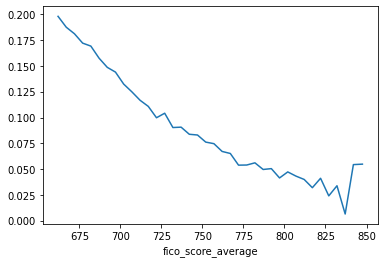

In [234]:
sns.lineplot(y=default_fico.values,x=default_fico.index, palette='hls')
plt.xlabel('FICO Score')
plt.ylabel('Default Rate')
plt.title('Default Rate vs FICO Score')
#save and add h-line avg

In [41]:
pd.set_option("display.max_columns", 200)
subset = approved.query("fico_avg>=840 and loan_status==0")
subset

,addr_state,annual_inc,application_type,disbursement_method,dti,earliest_cr_line,emp_length,emp_title,fico_range_high,fico_range_low,grade,home_ownership,initial_list_status,inq_last_6mths,installment,int_rate,issue_d,last_pymnt_d,loan_amnt,loan_status,open_acc,pub_rec,pub_rec_bankruptcies,purpose,sub_grade,term,total_pymnt,verification_status,zip_code,days_since_first_credit,fico_score_average,PnL,years,fico_avg
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7266455,FL,34000.0,Individual,Cash,10.76,1985-07-01,10,Bell Shoals Baptist Church,850.0,845.0,C,OWN,f,0.0,270.02,15.10,2013-09-01,2014-09-01,11325.0,0,11.0,0.0,0.0,other,12,60,5574.95,Source Verified,335xx,10289,847.5,-5750.05,2013,847.5
3625381,TX,48000.0,Individual,Cash,30.56,1992-06-01,10,Health Fitness Corporation,844.0,840.0,A,MORTGAGE,w,0.0,152.18,6.03,2013-03-01,2015-04-01,5000.0,0,13.0,0.0,0.0,credit_card,1,36,3998.07,Verified,752xx,7578,842.0,-1001.93,2013,842.0
10130799,NJ,59000.0,Individual,Cash,3.30,1989-10-01,8,Federal Police Sergeant,850.0,845.0,A,MORTGAGE,w,0.0,317.54,8.90,2014-01-01,2014-07-01,10000.0,0,8.0,0.0,0.0,home_improvement,5,36,7374.84,Source Verified,083xx,8858,847.5,-2625.16,2014,847.5
12316506,NC,50000.0,Individual,Cash,9.53,1988-10-01,7,Security Installer,844.0,840.0,C,MORTGAGE,w,0.0,850.20,13.65,2014-02-01,2015-12-01,25000.0,0,6.0,0.0,0.0,home_improvement,11,36,19636.05,Verified,284xx,9254,842.0,-5363.95,2014,842.0
26200698,IL,216000.0,Individual,Cash,4.43,1997-02-01,4,President,844.0,840.0,D,RENT,w,0.0,1235.52,16.29,2014-09-01,2017-07-01,35000.0,0,8.0,0.0,0.0,house,17,36,42007.68,Source Verified,600xx,6421,842.0,7007.68,2014,842.0
48545903,NC,75000.0,Individual,Cash,12.56,1986-07-01,-1,None,850.0,845.0,B,OWN,w,0.0,628.39,8.18,2015-05-01,NaT,20000.0,0,17.0,0.0,0.0,small_business,6,36,0.00,Source Verified,275xx,10531,847.5,-20000.00,2015,847.5
65374531,CA,14400.0,Individual,Cash,2.08,1986-04-01,10,cook,844.0,840.0,E,MORTGAGE,w,1.0,176.74,18.20,2015-11-01,2017-10-01,4875.0,0,7.0,0.0,0.0,other,21,36,4884.50,Source Verified,953xx,10806,842.0,9.50,2015,842.0
66633602,NY,40000.0,Individual,Cash,0.75,1993-03-01,-1,None,850.0,845.0,C,MORTGAGE,f,0.0,190.02,13.18,2015-12-01,2016-06-01,5625.0,0,6.0,0.0,0.0,moving,13,36,1136.00,Verified,107xx,8310,847.5,-4489.00,2015,847.5
67839977,NY,50000.0,Individual,Cash,0.84,1995-09-01,10,IT,844.0,840.0,C,MORTGAGE,w,0.0,736.93,12.59,2015-12-01,2016-07-01,22000.0,0,5.0,0.0,0.0,medical,12,36,6334.28,Not Verified,125xx,7396,842.0,-15665.72,2015,842.0


### Int Rate

Text(0.5, 1.0, 'Interest Rate Over Time')

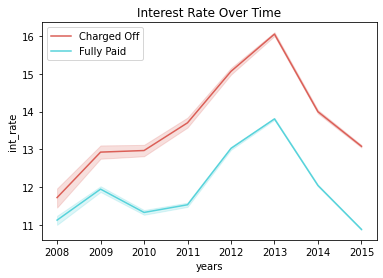

In [237]:
sns.lineplot(y='int_rate',x= 'years', hue='loan_status', data=approved, palette='hls')
plt.legend(['Charged Off', 'Fully Paid'])
plt.title('Interest Rate Over Time')

Text(0.5, 1.0, 'Interest Rate Over Time')

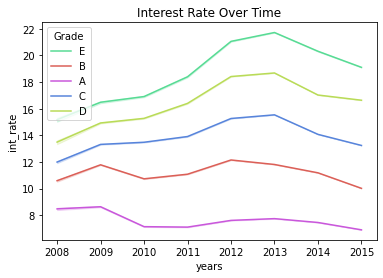

In [238]:
plot = sns.lineplot(y='int_rate',x='years', hue= 'grade', data=approved, palette='hls')

handles, labels = plot.get_legend_handles_labels()
handles = [handles[2], handles[0], handles[4], handles[3], handles[1]]
labels = [labels[2], labels[0], labels[4], labels[3], labels[1]]
plt.legend(handles,labels, title='Grade', loc=2)
plt.title('Interest Rate Over Time')
#save and fix

### DTI

Text(0.5, 1.0, 'DTI Over Time')

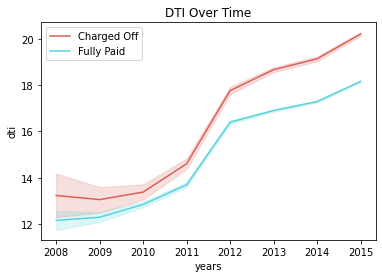

In [239]:
sns.lineplot(y='dti',x= 'years', hue='loan_status', data=approved, palette='hls')
plt.legend(['Charged Off', 'Fully Paid'])
plt.title('DTI Over Time')

<AxesSubplot:xlabel='years', ylabel='dti'>

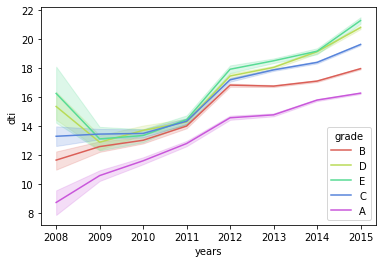

In [240]:
sns.lineplot(y='dti',x='years', hue= 'grade', data=approved, palette='hls')
#save and fix legend

In [241]:
approved['dti'].describe()

count    660896.000000
mean         17.544156
std           8.309068
min           0.000000
25%          11.390000
50%          17.050000
75%          23.250000
max         999.000000
Name: dti, dtype: float64

In [242]:
default_dti = approved.groupby('dti').mean()['loan_status']
default_dti = 1-default_dti
default_dti

dti
0.00      0.149425
0.01      0.125000
0.02      0.272727
0.03      0.142857
0.04      0.000000
            ...   
104.00    0.000000
120.66    0.000000
137.40    0.000000
672.52    0.000000
999.00    0.000000
Name: loan_status, Length: 4032, dtype: float64

In [243]:
approved['dti_cut'] = pd.qcut(approved.loc[approved['dti']>0,'dti'], q=10)
approved['dti_cut'].value_counts()

(12.59, 14.83]                  66295
(17.05, 19.35]                  66231
(24.79, 28.8]                   66084
(7.05, 10.13]                   66083
(10.13, 12.59]                  66082
(0.009000000000000001, 7.05]    66059
(21.84, 24.79]                  66051
(28.8, 999.0]                   66009
(19.35, 21.84]                  65844
(14.83, 17.05]                  65810
Name: dti_cut, dtype: int64

In [244]:
default_dti = approved.groupby('dti_cut').mean()['loan_status']
default_dti = 1-default_dti
default_dti

dti_cut
(0.009000000000000001, 7.05]    0.108418
(7.05, 10.13]                   0.114901
(10.13, 12.59]                  0.118308
(12.59, 14.83]                  0.127355
(14.83, 17.05]                  0.135496
(17.05, 19.35]                  0.146065
(19.35, 21.84]                  0.153651
(21.84, 24.79]                  0.164479
(24.79, 28.8]                   0.178772
(28.8, 999.0]                   0.197519
Name: loan_status, dtype: float64

Text(0.5, 1.0, 'DTI vs Default Rate')

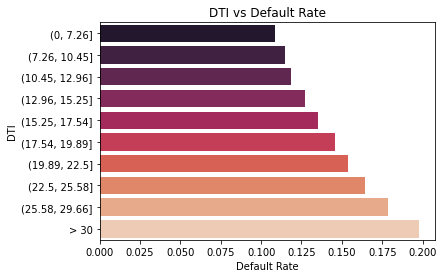

In [245]:
sns.barplot(x=default_dti.values,y=default_dti.index, palette='rocket')
plt.ylabel('DTI')
plt.xlabel('Default Rate')
plt.yticks([0, 1, 2,3,4,5,6,7,8,9], [
'(0, 7.26]',
'(7.26, 10.45]',
'(10.45, 12.96]',
'(12.96, 15.25]',
'(15.25, 17.54]',
'(17.54, 19.89]',
'(19.89, 22.5]',
'(22.5, 25.58]',
'(25.58, 29.66]',
'> 30'])
plt.title('DTI vs Default Rate')
#save and flip y axis
#try to make defaults %

In [246]:
approved['inc_cut'] = pd.qcut(approved.annual_inc, q=10)
approved['inc_cut'].value_counts()

(32000.0, 40000.0]       70388
(61000.0, 70000.0]       70299
(1199.999, 32000.0]      68599
(54103.88, 61000.0]      66965
(47840.0, 54103.88]      66016
(80000.0, 96000.0]       66003
(120000.0, 9000000.0]    65228
(96000.0, 120000.0]      64663
(70000.0, 80000.0]       63379
(40000.0, 47840.0]       59356
Name: inc_cut, dtype: int64

In [247]:
default_inc = approved.groupby('inc_cut').mean()['loan_status']
default_inc = 1-default_inc
default_inc

inc_cut
(1199.999, 32000.0]      0.198079
(32000.0, 40000.0]       0.176536
(40000.0, 47840.0]       0.163859
(47840.0, 54103.88]      0.155750
(54103.88, 61000.0]      0.150362
(61000.0, 70000.0]       0.139945
(70000.0, 80000.0]       0.130311
(80000.0, 96000.0]       0.118146
(96000.0, 120000.0]      0.108980
(120000.0, 9000000.0]    0.099022
Name: loan_status, dtype: float64

Text(0.5, 1.0, 'Annual Inc vs Default Rate')

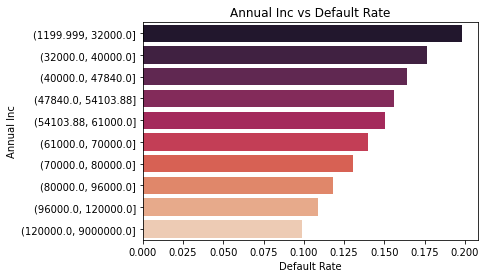

In [248]:
sns.barplot(x=default_inc.values,y=default_inc.index, palette='rocket')
plt.ylabel('Annual Inc')
plt.xlabel('Default Rate')
plt.title('Annual Inc vs Default Rate')
#save

### Loan Purposes

In [84]:
default_purpose = approved.groupby('purpose').mean()['loan_status']
default_purpose = 1-default_purpose
default_purpose = default_purpose.sort_values(ascending=False).head(10)

Text(0.5, 1.0, 'Loan Purpose vs Default Rate')

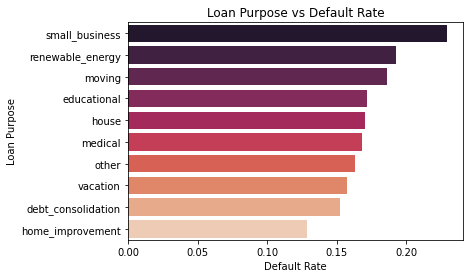

In [169]:
sns.barplot(x=default_purpose.values,y=default_purpose.index, palette='rocket')
plt.ylabel('Loan Purpose')
plt.xlabel('Default Rate')
plt.title('Loan Purpose vs Default Rate')

### Default Rate vs Verification Status

In [86]:
approved['verification_status'].value_counts()

Source Verified    228902
Not Verified       216483
Verified           215518
Name: verification_status, dtype: int64

In [87]:
approved['verification_status']= np.where(approved['verification_status']=='Source Verified','Verified',approved['verification_status'])

In [88]:
approved['verification_status'].value_counts()

Verified        444420
Not Verified    216483
Name: verification_status, dtype: int64

In [89]:
default_verif = approved.groupby('verification_status').mean()['loan_status']
default_verif = 1-default_verif

In [90]:
default_verif

verification_status
Not Verified    0.116406
Verified        0.158170
Name: loan_status, dtype: float64

Text(0.5, 1.0, 'Default Rate vs Verification Status')

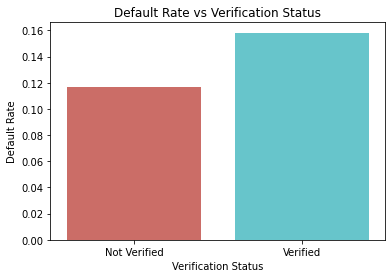

In [91]:
sns.barplot(y=default_verif.values,x=default_verif.index, palette='hls')
plt.xlabel('Verification Status')
plt.ylabel('Default Rate')
plt.title('Default Rate vs Verification Status')

### Emp Length

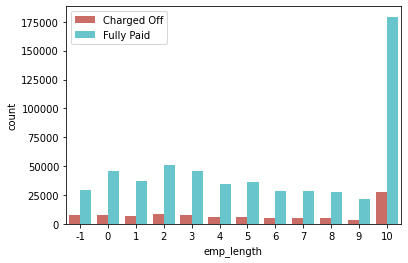

In [92]:
plt = sns.countplot(x='emp_length', hue='loan_status', data=approved, palette='hls')
plt.legend(['Charged Off', 'Fully Paid'])

In [97]:
default_emp = approved.groupby('emp_length').mean()['loan_status']
default_emp = 1-default_emp
default_emp

emp_length
-1     0.204954
 0     0.148739
 1     0.146902
 2     0.142259
 3     0.142919
 4     0.142678
 5     0.144148
 6     0.144258
 7     0.143979
 8     0.145071
 9     0.145525
 10    0.133460
Name: loan_status, dtype: float64

Text(0.5, 1.0, 'Default Rate vs Employment Length')

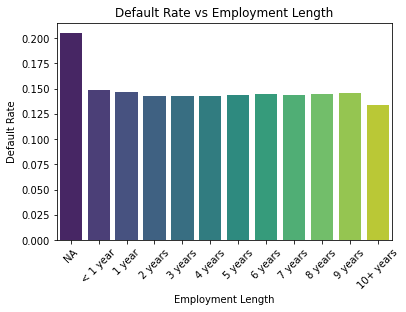

In [99]:
sns.barplot(y=default_emp.values,x=default_emp.index, palette="viridis")
plt.xlabel('Employment Length')
plt.ylabel('Default Rate')
plt.xticks([0, 1, 2,3,4,5,6,7,8,9,10,11], ['NA','< 1 year', '1 year', 
            '2 years', '3 years', '4 years', '5 years', '6 years', 
            '7 years', '8 years', '9 years', '10+ years'])
plt.xticks(rotation=45)
plt.title('Default Rate vs Employment Length')

In [ ]:
# make it NA or not

In [172]:
approved['home_ownership'].value_counts()


MORTGAGE    315555
RENT        279594
OWN          65576
OTHER          139
NONE            37
ANY              2
Name: home_ownership, dtype: int64

In [82]:
home = approved.copy()

In [83]:
home['home_ownership'].replace('MORTGAGE', 'OWN', inplace = True)

In [84]:
home['home_ownership'].replace('OWN', 'Home Ownership', inplace = True)

In [85]:
home['home_ownership'].replace('RENT', 'Rent', inplace = True)
home['home_ownership'].replace('HOME OWNERSHIP', 'Home Ownership', inplace = True)

In [86]:
home = home[~home['home_ownership'].isin(['OTHER', 'NONE', 'ANY'])]

In [87]:
default_home = home.groupby('home_ownership').mean()['loan_status']
default_home = (1-default_home) * 100
default_home

home_ownership
Home Ownership    12.779238
Rent              16.722581
Name: loan_status, dtype: float64

[Text(0, 0.5, 'Default Rate (%)'),
 Text(0.5, 0, 'Home Ownership Status'),
 Text(0.5, 1.0, 'Default Rate vs Home Ownership')]

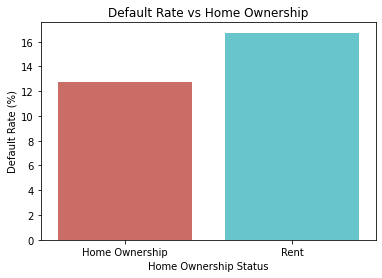

In [88]:
fig = sns.barplot(x=default_home.index, y=default_home.values, data=approved, palette='hls')
fig.set(title = 'Default Rate vs Home Ownership', xlabel = 'Home Ownership Status', ylabel = 'Default Rate (%)')
#remove any and order
#mortgage, own = home ownership and rent - 2 bars

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

## Default rate vs # of credit inquiries

In [48]:
approved['inq']=np.where(approved['inq_last_6mths']>=4,4,approved['inq_last_6mths'])

In [53]:
default_inqs = approved.groupby('inq').mean()['loan_status']
default_inqs = (1-default_inqs) * 100
default_inqs

inq
0.0    12.609367
1.0    15.599931
2.0    18.008927
3.0    19.875119
4.0    20.484973
Name: loan_status, dtype: float64

In [54]:
approved['inq'].value_counts()

0.0    369741
1.0    180879
2.0     71248
3.0     28347
4.0     10681
Name: inq, dtype: int64

([<matplotlib.axis.XTick at 0x1eb8120fe50>,
 [Text(0, 0, '0.0'),
  Text(0, 0, '1.0'),
  Text(0, 0, '2.0'),
  Text(0, 0, '3.0'),
  Text(0, 0, '4.0+')])

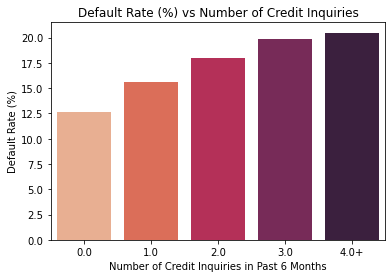

In [55]:
sns.barplot(y=default_inqs.values,x=default_inqs.index, palette="rocket_r")
plt.xlabel('Number of Credit Inquiries in Past 6 Months')
plt.ylabel('Default Rate (%)')
plt.title('Default Rate (%) vs Number of Credit Inquiries')
plt.xticks([0,1,2,3,4], ['0.0', '1.0', '2.0', '3.0', '4.0+'])
#save and make it 4.0+

In [106]:
approved.query("inq_last_6mths==8")

,addr_state,annual_inc,application_type,disbursement_method,dti,earliest_cr_line,emp_length,emp_title,fico_range_high,fico_range_low,grade,home_ownership,initial_list_status,inq_last_6mths,installment,int_rate,issue_d,last_pymnt_d,loan_amnt,loan_status,open_acc,pub_rec,pub_rec_bankruptcies,purpose,sub_grade,term,total_pymnt,verification_status,zip_code,days_since_first_credit,fico_score_average,PnL,years,fico_avg,default_year,dti_cut,inc_cut
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
533380,MA,33000.0,Individual,Cash,14.94,1997-10-01,10,cvs pharmacy,744.0,740.0,D,MORTGAGE,f,8.0,122.45,16.32,2010-06-01,2011-12-01,5000.0,1,20.0,0.0,0.0,home_improvement,20,60,6048.103124,Verified,020xx,4626,742.0,1048.103124,2010,742.0,2011,"(14.83, 17.05]","(32000.0, 40000.0]"
657025,CO,27600.0,Individual,Cash,16.83,1976-12-01,7,Alamosa Public Schools,769.0,765.0,D,MORTGAGE,f,8.0,333.03,15.65,2011-01-01,2016-02-01,13800.0,1,11.0,0.0,0.0,car,19,60,19981.643198,Verified,811xx,12449,767.0,6181.643198,2011,767.0,2016,"(14.83, 17.05]","(1199.999, 32000.0]"
666496,IL,35000.0,Individual,Cash,24.75,1996-12-01,7,Roys Body Shop,744.0,740.0,D,OWN,f,8.0,124.48,15.28,2011-02-01,2014-03-01,5200.0,1,7.0,0.0,0.0,car,18,60,7073.703155,Not Verified,629xx,5175,742.0,1873.703155,2011,742.0,2014,"(21.84, 24.79]","(32000.0, 40000.0]"
696388,MI,82000.0,Individual,Cash,14.59,1994-01-01,10,Northville Public Schools,799.0,795.0,D,MORTGAGE,f,8.0,335.13,15.28,2011-03-01,2016-03-01,14000.0,1,10.0,0.0,0.0,home_improvement,18,60,20105.810027,Verified,481xx,6268,797.0,6105.810027,2011,797.0,2016,"(12.59, 14.83]","(80000.0, 96000.0]"
766671,FL,146000.0,Individual,Cash,9.96,1996-07-01,10,Marriott International,749.0,745.0,E,MORTGAGE,f,8.0,639.54,17.88,2011-06-01,2012-03-01,35000.0,1,9.0,0.0,0.0,debt_consolidation,25,60,28489.760904,Verified,331xx,5448,747.0,-6510.239096,2011,747.0,2012,"(7.05, 10.13]","(120000.0, 9000000.0]"
884507,MI,30000.0,Individual,Cash,22.96,1978-09-01,8,golden brown bakery,759.0,755.0,D,OWN,f,8.0,49.46,16.77,2011-09-01,2016-10-01,2000.0,1,6.0,0.0,0.0,other,17,60,2967.427698,Not Verified,490xx,12053,757.0,967.427698,2011,757.0,2016,"(21.84, 24.79]","(1199.999, 32000.0]"
1368779,KY,218000.0,Individual,Cash,1.07,1985-10-01,10,Presbyterian Publishing Corp.,749.0,745.0,E,MORTGAGE,f,8.0,683.25,21.49,2012-07-01,2012-12-01,25000.0,1,5.0,0.0,0.0,debt_consolidation,23,60,27195.602034,Verified,402xx,9770,747.0,2195.602034,2012,747.0,2012,"(0.009000000000000001, 7.05]","(120000.0, 9000000.0]"
1587833,MI,82000.0,Individual,Cash,18.59,2000-06-01,10,kroger,754.0,750.0,D,MORTGAGE,w,8.0,649.21,19.05,2012-10-01,2017-03-01,25000.0,1,11.0,0.0,0.0,debt_consolidation,19,60,38656.019830,Verified,481xx,4505,752.0,13656.019830,2012,752.0,2017,"(17.05, 19.35]","(80000.0, 96000.0]"
353370,CO,42000.0,Individual,Cash,23.63,1994-04-01,2,Jefferson count schools,744.0,740.0,C,RENT,f,8.0,165.86,11.91,2008-08-01,2010-01-01,5000.0,1,19.0,0.0,0.0,credit_card,13,36,5678.670000,Not Verified,805xx,5236,742.0,678.670000,2008,742.0,2010,"(21.84, 24.79]","(40000.0, 47840.0]"


In [57]:
x=approved['total_pymnt'].loc[approved['loan_status']==0]
x

id
56121         5145.48
57167         6073.10
61419         6475.33
65104         7123.75
119043       11652.85
               ...   
144852610      247.76
145011883      857.96
145038052        0.00
145042659      640.22
145455851        0.00
Name: total_pymnt, Length: 249333, dtype: float64

### How much of principal is typically paid off before default? Broken out by loan grade?

In [132]:
approved.groupby('grade')['PnL'].mean()

grade
A    1001.756625
B    1167.453831
C    1278.124600
D    1271.522546
E    1867.478122
Name: PnL, dtype: float64

[Text(0, 0.5, 'Average Profit $'),
 Text(0.5, 0, 'Grade'),
 Text(0.5, 1.0, 'Profit/Loss by Grade')]

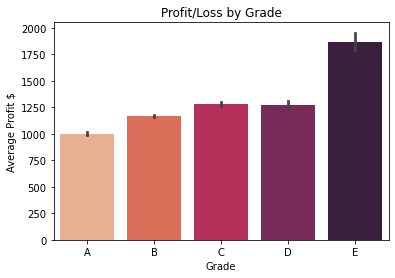

In [47]:
my_order = ['A','B','C','D','E']
fig = sns.barplot(y='PnL',x='grade',data=approved,order=my_order, palette='rocket_r')
fig.set(title = 'Profit/Loss by Grade', xlabel = 'Grade', ylabel = 'Average Profit $')

## True life of loans [last_pmnt_d - issue_d] vs term (36/60)

In [24]:
approved['tru_life']=approved['last_pymnt_d']-approved['issue_d']

In [25]:
approved['tru_life']

id
66943       426 days
69550      1553 days
380713     1400 days
391748     1369 days
419640     1491 days
              ...   
68616825    943 days
68616851    578 days
68616873    487 days
68616891   1096 days
68616919    852 days
Name: tru_life, Length: 660896, dtype: timedelta64[ns]

In [26]:
approved['tru_months'] = approved['tru_life'].dt.days / 30.4167

In [139]:
approved['tru_months'].describe()

count    660416.000000
mean         25.335582
std          12.078387
min           0.000000
25%          15.057518
50%          27.024628
75%          36.032837
max          70.027321
Name: tru_months, dtype: float64

In [43]:
approved['true']=(approved['tru_months']/approved['term']) * 100

In [41]:
my_labels=['Charged Off', 'Fully Paid']
handles, labels = fig.get_legend_handles_labels()
handles = [handles[0], handles[1]]
labels = my_labels

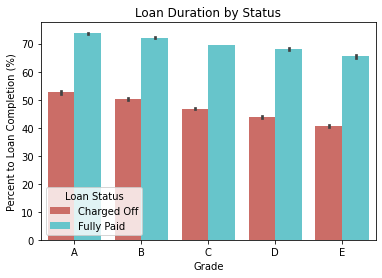

In [57]:
my_order = ['A','B','C','D','E']
fig = sns.barplot(x='grade', y='true',hue='loan_status', data=approved, palette='hls', order=my_order)
fig.set(title = 'Loan Duration by Status', xlabel = 'Grade', ylabel = 'Percent to Loan Completion (%)')
plt.legend(handles,labels, title='Loan Status', loc=3)
#save fix axis

#talk ab prepayment risk vs default risk

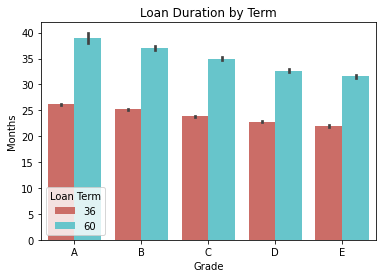

In [34]:
my_order = ['A','B','C','D','E']
fig = sns.barplot(x='grade', y='tru_months', hue='term', data=approved, palette='hls', order=my_order)
fig.set(title = 'Loan Duration by Term', xlabel = 'Grade', ylabel = 'Months')
fig.legend(title = 'Loan Term', loc = 'lower left')
#save

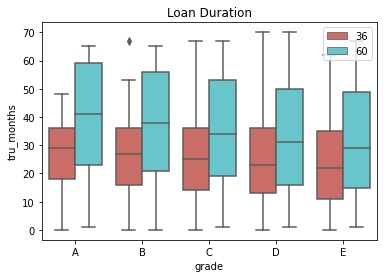

In [144]:
my_order = ['A','B','C','D','E']
sns.boxplot(x='grade', y='tru_months', hue='term', data=approved, palette='hls', order=my_order)
plt.title('Loan Duration')
plt.legend(loc=1)

In [142]:
approved.groupby(['term','grade'])[['tru_months']].median()

tru_months
term grade            
36   A       29.030105
     B       27.057505
     C       25.052027
     D       23.046550
     E       22.027373
60   A       41.062969
     B       37.972561
     C       34.060237
     D       31.002706
     E       29.030105

In [143]:
approved.groupby('term')[['tru_months']].median()

,tru_months
term,
36,26.958875
60,33.041060


<AxesSubplot:xlabel='term', ylabel='tru_months'>

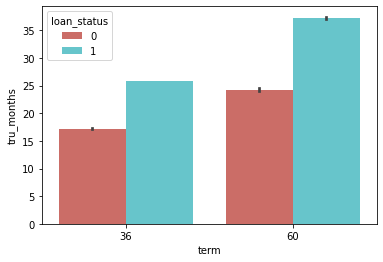

In [145]:
fig = sns.barplot(x='term', y='tru_months', hue='loan_status', data=approved, palette='hls')

In [115]:
approved['zip_code'].value_counts().head(10)

945xx    14555
750xx    14029
112xx    13339
606xx    12090
300xx    11699
331xx    10968
070xx    10424
891xx    10294
100xx    10273
900xx    10267
Name: zip_code, dtype: int64

In [148]:
default_zip = approved.groupby('zip_code').agg({'loan_status':['mean','count']})
default_zip.sort_values(by=('loan_status','count'),ascending=False).head(20)
default_zip.columns=['default_rate','count']
default_zip.default_rate = 1 - default_zip.default_rate
subset = default_zip.query("count>20 and default_rate<=.2")
subset.sort_values(by='default_rate',ascending=False)


,default_rate,count
zip_code,,
576xx,0.200000,25
997xx,0.200000,575
652xx,0.200000,805
417xx,0.200000,70
025xx,0.200000,575
...,...,...
878xx,0.105263,57
830xx,0.090909,88
022xx,0.084746,118


In [146]:
default_state = approved.groupby('addr_state').mean()['loan_status']
default_state = 1-default_state
default_state.sort_values(ascending=False)

addr_state
IA    0.333333
NE    0.191744
MS    0.183218
NV    0.177083
AR    0.175842
OK    0.171555
AL    0.168669
TN    0.163995
LA    0.161705
FL    0.159488
NY    0.157492
SD    0.157394
MO    0.157256
NM    0.156613
IN    0.154382
ND    0.153595
NJ    0.151851
OH    0.149827
NC    0.149025
MD    0.148214
KY    0.147210
MI    0.146165
AZ    0.146163
CA    0.146013
PA    0.145152
MN    0.144751
HI    0.144621
DE    0.144068
VA    0.143076
RI    0.138099
AK    0.137931
TX    0.137741
UT    0.132543
MA    0.132151
GA    0.129085
CT    0.126706
WI    0.126268
IL    0.125679
MT    0.122332
WA    0.120602
SC    0.118019
OR    0.117984
CO    0.117231
KS    0.114627
WY    0.113195
WV    0.111771
ME    0.104790
VT    0.102308
NH    0.098734
DC    0.093588
ID    0.000000
Name: loan_status, dtype: float64

In [150]:
approved['addr_state'].value_counts()

CA    101676
NY     56295
TX     53216
FL     46367
IL     26695
NJ     24669
PA     22473
GA     21389
OH     21131
VA     18934
NC     17695
MI     17015
AZ     15428
MA     15278
MD     15120
WA     14610
CO     13853
MN     11689
MO     10378
CT     10110
NV      9696
IN      9483
TN      8921
WI      8577
OR      8391
AL      7909
LA      7693
SC      7592
KY      6039
OK      5864
KS      5784
AR      4868
UT      4557
NM      3697
HI      3402
NH      3160
WV      3033
RI      2882
MS      2467
DC      1934
MT      1921
DE      1770
AK      1682
WY      1493
SD      1366
VT      1300
NE       751
ME       334
ND       306
ID         7
IA         3
Name: addr_state, dtype: int64

In [151]:
approved['disbursement_method'].value_counts()

Cash    660903
Name: disbursement_method, dtype: int64

In [15]:
default_state = approved.groupby('disbursement_method').mean()['loan_status']
default_state = 1-default_state
default_state.sort_values(ascending=False)

disbursement_method
Cash    0.144489
Name: loan_status, dtype: float64

In [16]:
approved['days_since_first_credit'] = approved['issue_d'] - approved['earliest_cr_line']

In [17]:
approved['days_since_first_credit'] = approved['days_since_first_credit'].dt.days

In [18]:
approved['days_cut'] = pd.qcut(approved.days_since_first_credit, q=10)
approved['days_cut'].value_counts()

(1094.999, 2861.0]    66771
(4291.0, 4809.0]      66722
(6788.0, 7852.0]      66121
(2861.0, 3713.0]      66118
(5355.0, 5967.0]      66081
(9677.0, 25933.0]     66081
(7852.0, 9677.0]      66008
(5967.0, 6788.0]      65965
(4809.0, 5355.0]      65543
(3713.0, 4291.0]      65486
Name: days_cut, dtype: int64

In [19]:
default_day = approved.groupby('days_cut').mean()['loan_status']
default_day = (1-default_day) * 100
default_day.sort_values(ascending=False)

days_cut
(1094.999, 2861.0]    17.133187
(2861.0, 3713.0]      15.966908
(3713.0, 4291.0]      15.838500
(4291.0, 4809.0]      15.161416
(4809.0, 5355.0]      14.683490
(5355.0, 5967.0]      14.224966
(5967.0, 6788.0]      13.723945
(6788.0, 7852.0]      12.953525
(9677.0, 25933.0]     12.418093
(7852.0, 9677.0]      12.360623
Name: loan_status, dtype: float64

Text(0.5, 1.0, 'Credit History vs Default Rate %')

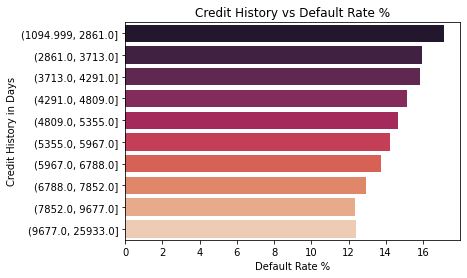

In [21]:
sns.barplot(x=default_day.values,y=default_day.index, palette='rocket')
plt.ylabel('Credit History in Days')
plt.xlabel('Default Rate %')
plt.title('Credit History vs Default Rate %')
#save